<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/notebooks/supervised-learning/feature-ablation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
import pickle

import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, ParameterGrid, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
repo_path = '/content/drive/MyDrive/milestone-ii/'
train_path = ''.join([repo_path, 'Training_set.csv'])
test_path = ''.join([repo_path, 'Testing_set.csv'])

df_train = pd.read_csv(train_path, sep='\t', index_col='ix')
df_train['lemmatized_text'] = df_train['lemmatized_text'].fillna('')
df_test = pd.read_csv(test_path, sep='\t', index_col='ix')
df_test['lemmatized_text'] = df_test['lemmatized_text'].fillna('')

df = pd.concat([df_train, df_test])
print(df.shape)
df.head(2)

(416768, 11)


,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,there be manuscript evidence that austen conti...,8.236551,5.809310,3.57,12.12,2.495517,1.33,4.57,37.0,1
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,12.320171,7.499286,2.89,11.94,2.251429,1.46,3.77,21.0,1


In [7]:
readability_features = ['d_chall_score',	'aoa_mean',	'aoa_min',	'aoa_max',	
                        'conc_rating_mean',	'conc_rating_min',	'conc_rating_max']

text_features = 'lemmatized_text'

def build_clf(tfidf_kwargs={}, clf_kwargs={}, include_num_features=True):
  num_pipe = Pipeline([
      ('impute', SimpleImputer(strategy='mean')),
      ('scale', StandardScaler()),
      ('binner', KBinsDiscretizer(n_bins=4)),
  ])

  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_kwargs)),
  ])

  if include_num_features:
    preprocessor = [('num', num_pipe, readability_features), 
                    ('text', text_pipe, text_features),]
  else:
    preprocessor = [('text', text_pipe, text_features)]

  preprocessor = ColumnTransformer(preprocessor)

  clf = Pipeline([
      ('preprocessor', preprocessor),
      ('clf', LinearSVC(**clf_kwargs))
  ])
  return clf

In [ ]:
TfidfVectorizer(**dict(min_df=50, ngram_range=(1, 3))).fit_transform(df['lemmatized_text']).shape

(416768, 29036)

In [9]:
clf_kwargs=dict(dual=False, C=.5, penalty='l1', random_state=99)

all_feature_clf = build_clf(tfidf_kwargs=dict(min_df=50, ngram_range=(1, 3)), 
                            clf_kwargs=clf_kwargs)

text_clf = build_clf(tfidf_kwargs=dict(min_df=50, ngram_range=(1, 3)), 
                     clf_kwargs=clf_kwargs,
                     include_num_features=False)

text_5000_clf = build_clf(tfidf_kwargs=dict(min_df=50, ngram_range=(1, 3), max_features=5000), 
                     clf_kwargs=clf_kwargs,
                     include_num_features=False)

text_2500_clf = build_clf(tfidf_kwargs=dict(min_df=50, ngram_range=(1, 3), max_features=2500), 
                     clf_kwargs=clf_kwargs,
                     include_num_features=False)

text_1000_clf = build_clf(tfidf_kwargs=dict(min_df=50, ngram_range=(1, 3), max_features=1000), 
                     clf_kwargs=clf_kwargs,
                     include_num_features=False)

text_500_clf = build_clf(tfidf_kwargs=dict(min_df=50, ngram_range=(1, 3), max_features=500), 
                     clf_kwargs=clf_kwargs,
                     include_num_features=False)

text_100_clf = build_clf(tfidf_kwargs=dict(min_df=50, ngram_range=(1, 3), max_features=100), 
                     clf_kwargs=clf_kwargs,
                     include_num_features=False)

clf_list = [(all_feature_clf, 'All Features (Readability + 29,036 TFIDF Features)'), 
            (text_clf,      'Remove Readability Features'), 
            (text_5000_clf, 'Reduce to Top 5000 TFIDF Features'), 
            (text_2500_clf, 'Reduce to Top 2500 TFIDF Features'), 
            (text_1000_clf, 'Reduce to Top 1000 TFIDF Features'), 
            (text_500_clf,  'Reduce to Top 500 TFIDF Features'), 
            (text_100_clf,  'Reduce to Top 100 TFIDF Features'), ]

In [ ]:
def get_feature_ablation_results():
  cv_result_dict = {}
  cv = StratifiedKFold(n_splits=10)

  for clf, step_title in clf_list:
    cv_results = cross_validate(clf, df, df.label, n_jobs=-1, scoring=['roc_auc', 'accuracy', 'f1'], cv=cv)
    cv_result_dict[step_title] = cv_results
    print(step_title, cv_results)
    
  return cv_result_dict

cv_result_dict = get_feature_ablation_results()

In [13]:
# filename = 'feature-ablation-results'
# file_path = ''.join([repo_path, filename])

# with open(file_path, 'wb') as fh:
#   pickle.dump(cv_result_dict, fh)

In [21]:
filename = 'feature-ablation-results'
file_path = ''.join([repo_path, filename])

with open(file_path, 'rb') as fh:
  cv_result_dict = pickle.load(fh, encoding='bytes')

cv_result_dict.keys() 

dict_keys(['All Features (Readability + 29,036 TFIDF Features)', 'Remove Readability Features', 'Reduce to Top 5000 TFIDF Features', 'Reduce to Top 2500 TFIDF Features', 'Reduce to Top 1000 TFIDF Features', 'Reduce to Top 500 TFIDF Features', 'Reduce to Top 100 TFIDF Features'])

In [19]:
cv_result_dict['All Features (Readability + 29,036 TFIDF Features)']

{'fit_time': array([117.92696929, 118.76559997, 127.38840127, 127.34252787,
        102.02744031,  86.1071918 , 128.36155295, 138.16174364,
        128.52023625, 120.69762874]),
 'score_time': array([5.19354057, 4.93540025, 5.27417994, 5.0719645 , 4.98158407,
        5.92072868, 5.70458364, 4.97126794, 5.59283566, 3.28191781]),
 'test_roc_auc': array([0.80241314, 0.79942852, 0.80271263, 0.8007074 , 0.79617728,
        0.80175435, 0.80115324, 0.80095759, 0.79820598, 0.79316044]),
 'test_accuracy': array([0.72462029, 0.72068527, 0.72368453, 0.72450032, 0.72078125,
        0.72433237, 0.72406843, 0.72668378, 0.72336597, 0.71633554]),
 'test_f1': array([0.72476558, 0.71927075, 0.72353195, 0.72385762, 0.71986712,
        0.72490003, 0.72319838, 0.72673624, 0.72210572, 0.71561222])}

In [29]:
columns = ['Feature Set', 'ROC AUC (Mean)', 'ROC AUC (95 % CI)', 'Accuracy (Mean)', 'Accuracy (95 % CI)', 'F1 (Mean)', 'F1 (95 % CI)']
results = pd.DataFrame(columns=columns)

for model_name in cv_result_dict.keys():
  y_auc = cv_result_dict[model_name]['test_roc_auc']
  y_acc = cv_result_dict[model_name]['test_accuracy']
  y_f1 = cv_result_dict[model_name]['test_f1']

  mean_auc = np.round(y_auc.mean(), 3)
  mean_acc = np.round(y_acc.mean(), 3)
  mean_f1  = np.round(y_f1.mean(),  3)

  low_auc, high_auc = st.t.interval(alpha=0.95, df=y_auc.shape[0]-1, loc=mean_auc, scale=st.sem(y_auc))
  low_auc, high_auc = np.round(low_auc, 3), np.round(high_auc, 3)

  low_acc, high_acc = st.t.interval(alpha=0.95, df=y_acc.shape[0]-1, loc=mean_acc, scale=st.sem(y_acc))
  low_acc, high_acc = np.round(low_acc, 3), np.round(high_acc, 3)
  
  low_f1, high_f1 = st.t.interval(alpha=0.95, df=y_f1.shape[0]-1, loc=mean_f1, scale=st.sem(y_f1))
  low_f1, high_f1 = np.round(low_f1, 3), np.round(high_f1, 3)

  results = results.append(pd.DataFrame([[model_name, 
                                          mean_auc, str((low_auc, high_auc)), 
                                          mean_acc, str((low_acc, high_acc)),
                                          mean_f1, str((low_f1, high_f1))]], columns=columns), ignore_index=True)
  
results

,Feature Set,ROC AUC (Mean),ROC AUC (95 % CI),Accuracy (Mean),Accuracy (95 % CI),F1 (Mean),F1 (95 % CI)
0,"All Features (Readability + 29,036 TFIDF Featu...",0.800,"(0.798, 0.802)",0.723,"(0.721, 0.725)",0.722,"(0.72, 0.724)"
1,Remove Readability Features,0.797,"(0.795, 0.799)",0.721,"(0.719, 0.723)",0.720,"(0.717, 0.723)"
2,Reduce to Top 5000 TFIDF Features,0.776,"(0.775, 0.777)",0.703,"(0.702, 0.704)",0.702,"(0.7, 0.704)"
3,Reduce to Top 2500 TFIDF Features,0.765,"(0.764, 0.766)",0.694,"(0.692, 0.696)",0.694,"(0.692, 0.696)"
4,Reduce to Top 1000 TFIDF Features,0.744,"(0.743, 0.745)",0.677,"(0.676, 0.678)",0.679,"(0.678, 0.68)"
5,Reduce to Top 500 TFIDF Features,0.730,"(0.729, 0.731)",0.664,"(0.663, 0.665)",0.670,"(0.668, 0.672)"
6,Reduce to Top 100 TFIDF Features,0.685,"(0.684, 0.686)",0.633,"(0.631, 0.635)",0.645,"(0.644, 0.646)"


In [48]:
x_tick_map ={
 'All Features (Readability + 29,036 TFIDF Features)':'Readability +\nAll TF IDF', 
 'Remove Readability Features': 'All TF IDF', 
 'Reduce to Top 5000 TFIDF Features':'Top 5000 TF IDF', 
 'Reduce to Top 2500 TFIDF Features':'Top 2500 TF IDF', 
 'Reduce to Top 1000 TFIDF Features':'Top 1000 TF IDF', 
 'Reduce to Top 500 TFIDF Features':'Top 500 TF IDF', 
 'Reduce to Top 100 TFIDF Features':'Top 100 TF IDF'
}

In [82]:
cv_result_dict

{'All Features (Readability + 29,036 TFIDF Features)': {'fit_time': array([117.92696929, 118.76559997, 127.38840127, 127.34252787,
         102.02744031,  86.1071918 , 128.36155295, 138.16174364,
         128.52023625, 120.69762874]),
  'score_time': array([5.19354057, 4.93540025, 5.27417994, 5.0719645 , 4.98158407,
         5.92072868, 5.70458364, 4.97126794, 5.59283566, 3.28191781]),
  'test_roc_auc': array([0.80241314, 0.79942852, 0.80271263, 0.8007074 , 0.79617728,
         0.80175435, 0.80115324, 0.80095759, 0.79820598, 0.79316044]),
  'test_accuracy': array([0.72462029, 0.72068527, 0.72368453, 0.72450032, 0.72078125,
         0.72433237, 0.72406843, 0.72668378, 0.72336597, 0.71633554]),
  'test_f1': array([0.72476558, 0.71927075, 0.72353195, 0.72385762, 0.71986712,
         0.72490003, 0.72319838, 0.72673624, 0.72210572, 0.71561222])},
 'Remove Readability Features': {'fit_time': array([50.15677834, 50.84348226, 57.45147586, 63.69251847, 57.05068469,
         54.55161023, 59.7635

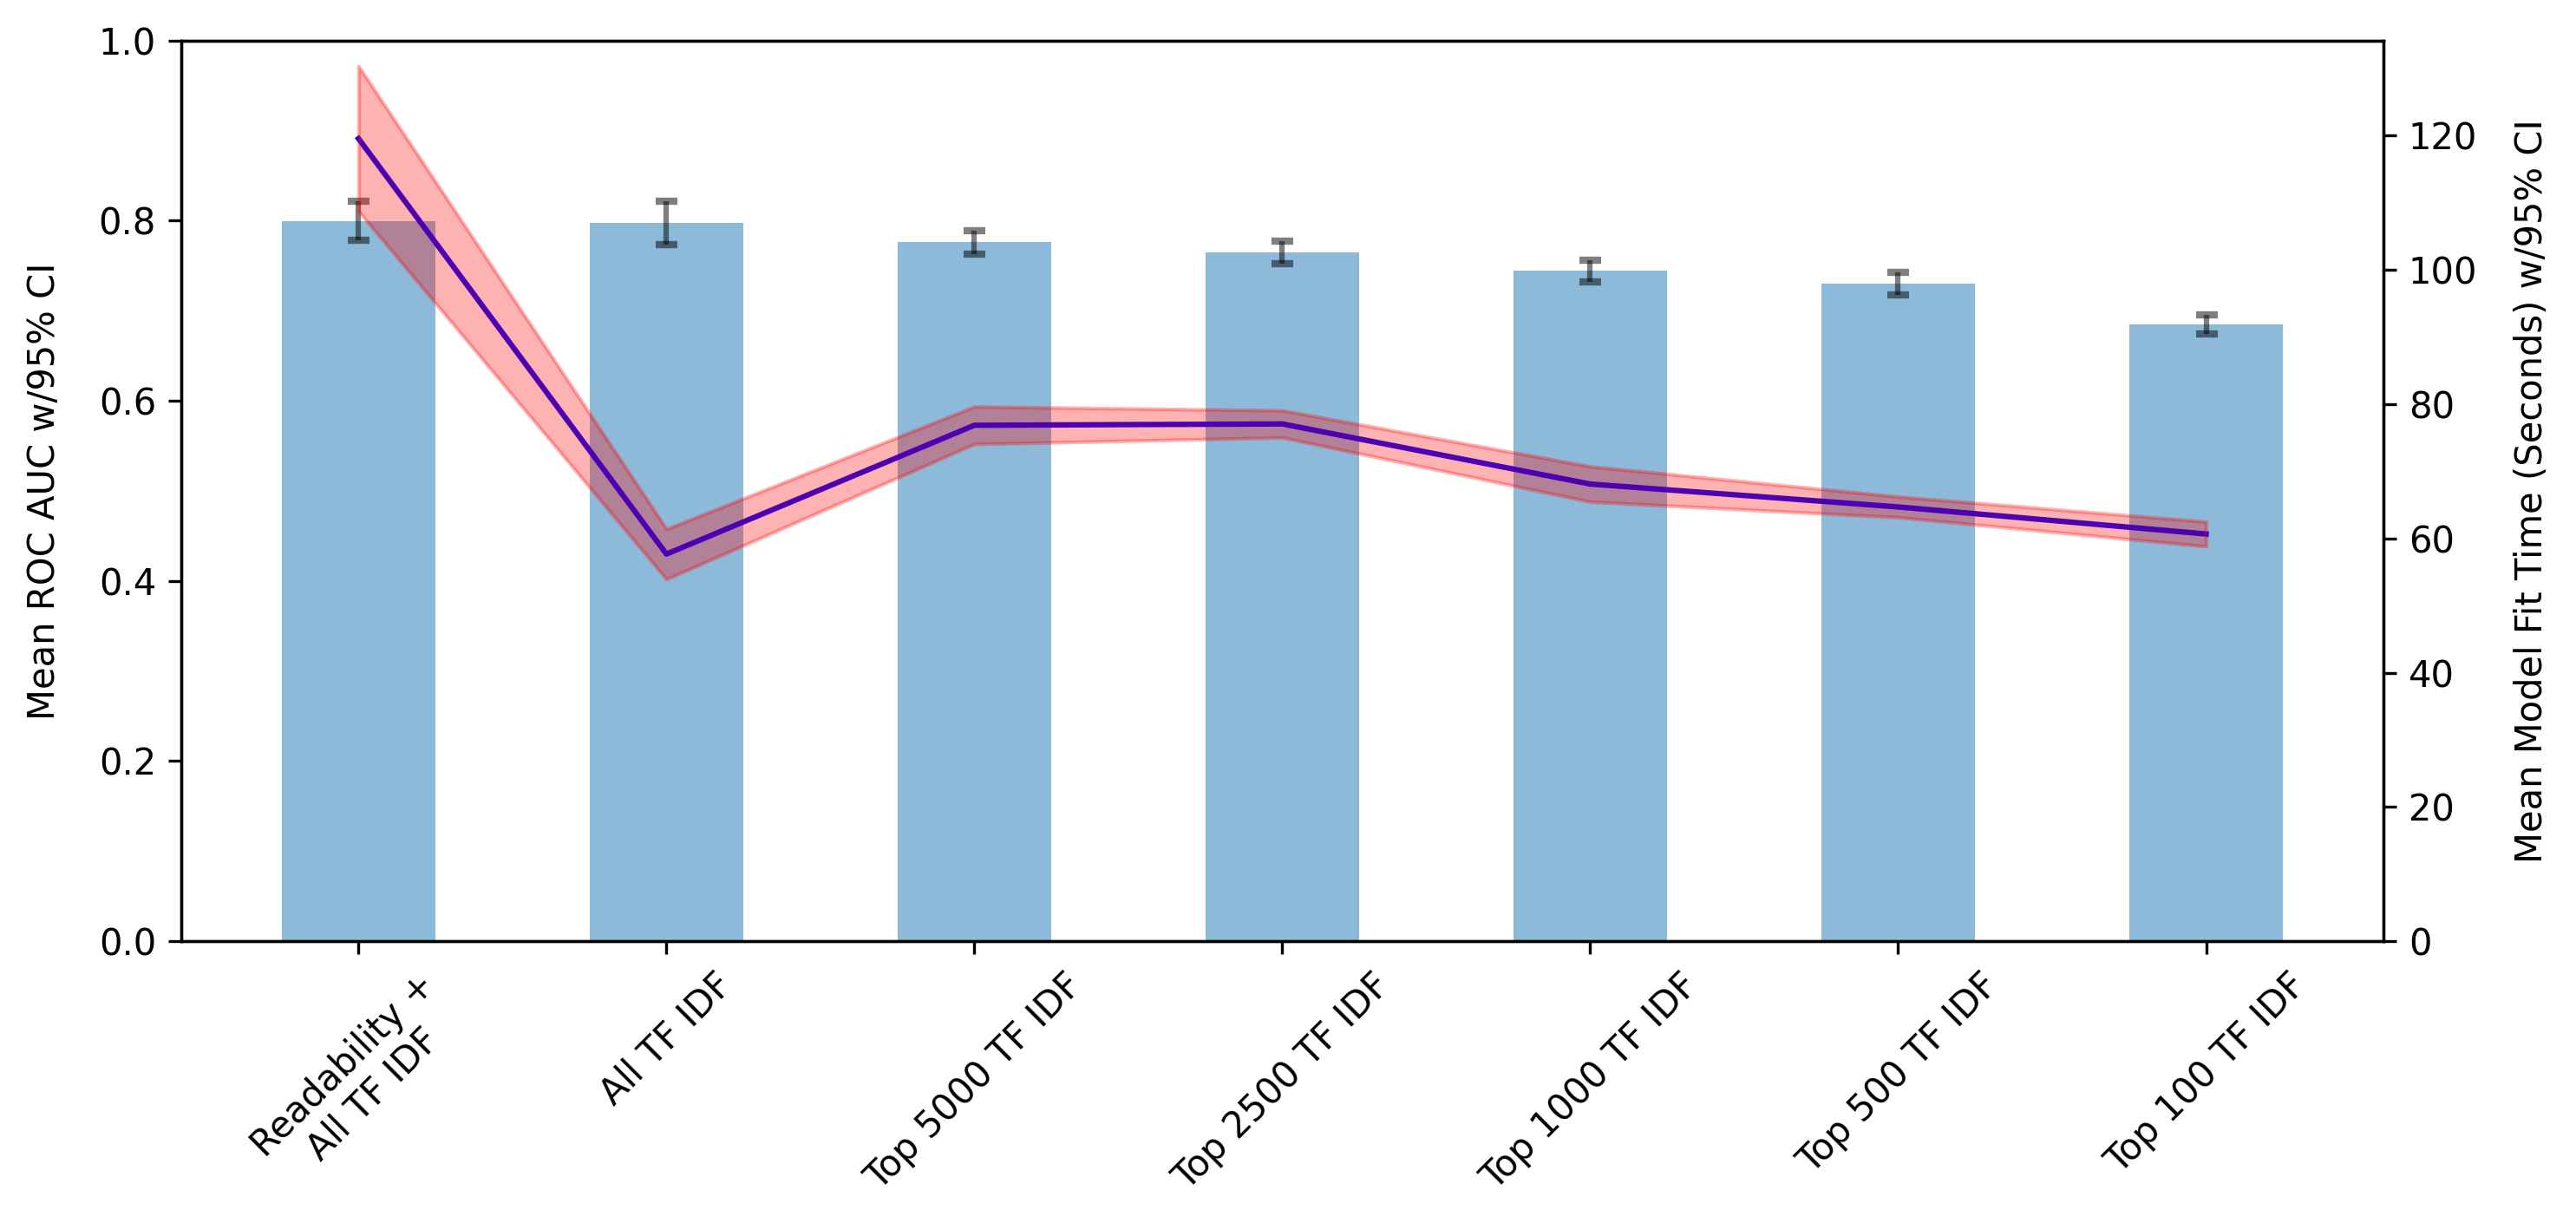

In [105]:
y_fit_time_means = np.zeros(len(cv_result_dict))
y_auc_means = np.zeros(len(cv_result_dict))

y_fit_time_ci_low = np.zeros(len(cv_result_dict))
y_fit_time_ci_high = np.zeros(len(cv_result_dict))

y_auc_ci_low = np.zeros(len(cv_result_dict))

for i, model_name in enumerate(cv_result_dict.keys()):
  y_fit_time = cv_result_dict[model_name]['fit_time']
  y_auc = cv_result_dict[model_name]['test_roc_auc']

  y_fit_time_means[i] = y_fit_time.mean()
  y_auc_means[i] = y_auc.mean()

  low_fit_time, high_fit_time = st.t.interval(alpha=0.95, df=y_fit_time.shape[0]-1, loc=y_fit_time_means[i], scale=st.sem(y_fit_time))
  low_auc, high_auc = st.t.interval(alpha=0.95, df=y_auc.shape[0]-1, loc=y_auc_means[i], scale=st.sem(y_auc))

  y_fit_time_ci_low[i] = low_fit_time
  y_fit_time_ci_high[i] = high_fit_time

  y_auc_ci_low[i] = low_auc

x = list(map(lambda x: x_tick_map[x], cv_result_dict.keys()))

fig = plt.figure(dpi=300, figsize=(10, 4.8))
ax1 = plt.gca()

ax1.bar(x, y_auc_means, width=.5, alpha=.5, zorder=0)
ax1.errorbar(x, y_auc_means, yerr=(y_auc_means-y_auc_ci_low)*10, barsabove=True, capsize=3, capthick=2, ecolor='black', color='None', alpha=.5, zorder=1)
ax1.set_ylim(0, 1)
ax1.set_ylabel('Mean ROC AUC w/95% CI', labelpad=10)

ax2 = ax1.twinx()
ax2.plot(x, y_fit_time_means, '-b', zorder=2)
ax2.fill_between(x, y_fit_time_ci_low, y_fit_time_ci_high, color='red', alpha=.3, zorder=3)
ax2.set_ylim(0)
ax2.set_ylabel('Mean Model Fit Time (Seconds) w/95% CI', labelpad=10)

for xlabel in ax1.get_xticklabels():
    xlabel.set_rotation(45)

fig.tight_layout()
plt.savefig('/content/drive/MyDrive/milestone-ii/feature-ablation-tradeoff.png', format='png', orientation='landscape')
plt.show()